In [8]:
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from aesara import tensor as at
from scipy import stats as st

%matplotlib inline
%config InlineBackend.figure_format = "retina"

As recommended by Michael, all shapes consist of prime numbers

In [2]:
µ, σ = -0.5, 3 # true data-generating parameters

Xs = np.random.normal(loc=µ, scale=σ, size=[5,])
Xnew = np.array([-3, -1, 0.5, 3.2, 4]) # N' = 5

Xs = Xs[..., np.newaxis]
Xnew = Xnew[..., np.newaxis]
    
K = 19

In [3]:
Xs

array([[ 2.12590158],
       [-2.75733533],
       [-2.02592251],
       [ 0.77498055],
       [-0.23436212]])

In [4]:
st.norm.cdf(Xnew.reshape(-1,), loc=µ, scale=σ)

array([0.20232838, 0.43381617, 0.63055866, 0.89127429, 0.9331928 ])

### Posterior of a Dirichlet Process

In [5]:
with pm.Model() as model:
    N = Xs.shape[0]
    
    dirac = at.sum(at.ge(Xnew, Xs.T), axis=1) # shape = (N',)
    dirac = at.as_tensor_variable(dirac) # shape = (N',)
    
    base_dist = pm.Normal("G0", 0, 3, shape=(K, 1)) # K draws
    weights = pm.Dirichlet(
        name="sticks",
        a=np.ones(shape=(K,)),
    )
    
    empirical_base_cdf = at.le(base_dist, Xnew.T)
    empirical_base_cdf = at.sum(at.mul(empirical_base_cdf.T, weights), axis=1)
    
    posterior_dp = pm.Deterministic(
        name="posterior-dp",
        var=empirical_base_cdf/(1 + N) + dirac/(1 + N),
    )
    
    trace = pm.sample(
        draws=1000,
        chains=1,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [G0, sticks]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 14 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


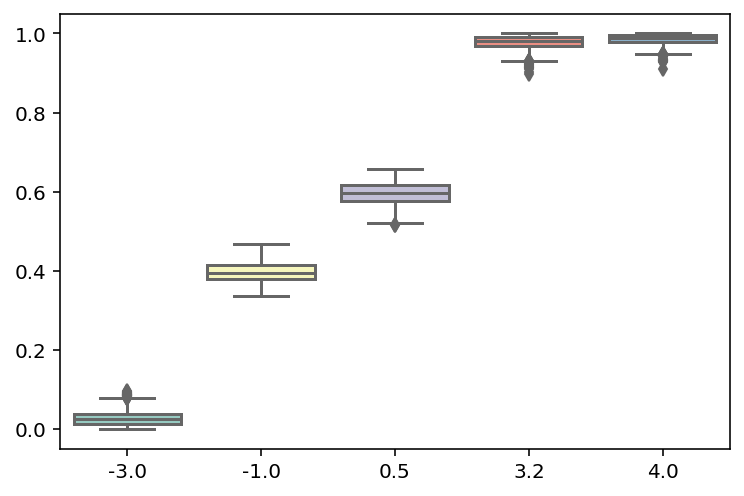

In [15]:
df = pd.DataFrame(trace.to_dict()["posterior"]["posterior-dp"][0], columns=Xnew.reshape(-1,))
_ = sns.boxplot(data=df, palette="Set3")

In [7]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu Jul 15 2021

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.25.0

pymc3  : 4.0
seaborn: 0.11.1
aesara : 2.0.12
scipy  : 1.7.0
numpy  : 1.21.0

Watermark: 2.2.0

